In [2]:
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyclustertend
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

## Análise exploratória

Primeiro, carregaremos os dados e analisaremos as distribuição das características dos grãos e as correlações entre elas.

In [3]:
df = pd.read_csv("data/trabalho4_dados_4.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            1143 non-null   int64  
 1   perimetro       1143 non-null   float64
 2   maior-eixo      1143 non-null   float64
 3   menor-eixo      1143 non-null   float64
 4   arredondamento  1143 non-null   float64
 5   area-convexa    1143 non-null   int64  
 6   extensao        1143 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 62.6 KB


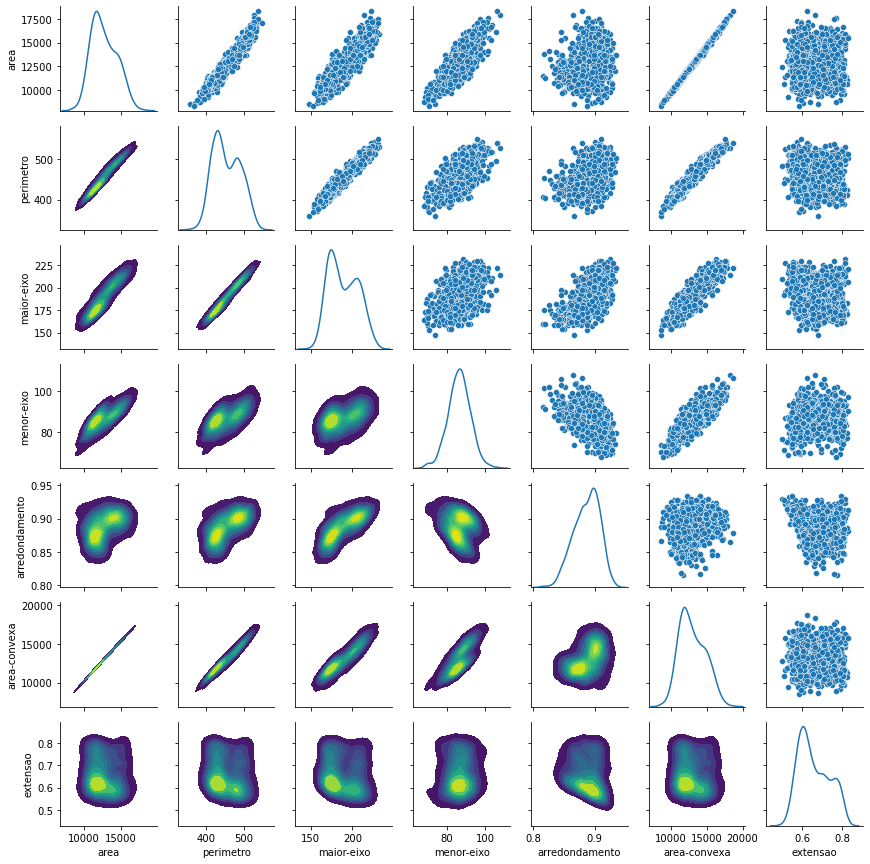

In [25]:
# Distribuição
g = sns.PairGrid(df, diag_sharey=False, height=1.75)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, fill=True, cmap="viridis")
g.map_diag(sns.kdeplot);
pairgrid = g

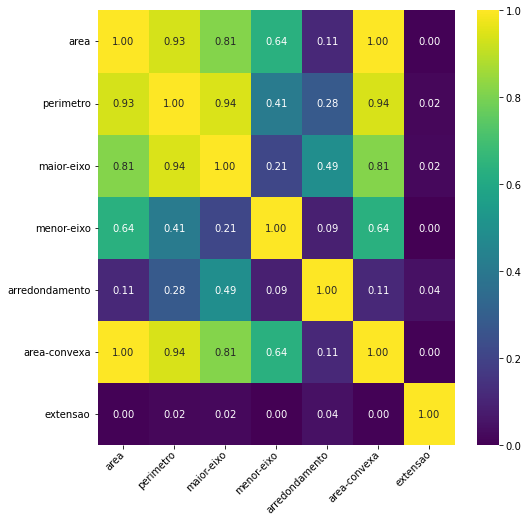

In [5]:
# Correlação linear (R^2)
plt.figure(figsize=(8, 8))
corr = df.corr()
g = sns.heatmap(corr ** 2, annot=True, vmin=0, vmax=1, fmt=".2f", cmap="viridis")
g.set_xticklabels(
    g.get_xticklabels(), rotation=45, va="center", ha="right", rotation_mode="anchor"
);

O primeiro gráfico revela duas informações interessantes:

- Em diversas das projeções, existem um ou dois picos de densidade bem definidos. No segundo caso, os dados projetados são facilmente separados em dois grupos.
- Algumas das características são fortemente correlacionadas (linearmente). Nesse caso, as características são redundantes para a tarefa de agrupamento e podemos remover algumas delas.
    - O segundo gráfico exibe as correlações lineares através do índice $R^2$.

## Tendência de agrupamento

A seguir, verificaremos a aleatoriedade espacial dos dados através da estatística de Hopkins para diferentes configurações de características. Mas, antes, padronizaremos os dados.

In [9]:
# Padronizar os dados
X = pd.DataFrame()
X[df.columns] = scale(df[df.columns])
X.describe()

,area,perimetro,maior-eixo,menor-eixo,arredondamento,area-convexa,extensao
count,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03,1.143000e+03
mean,-3.590013e-16,1.272240e-15,1.225811e-16,6.478729e-16,3.847025e-15,2.121371e-16,-1.798892e-16
std,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00,1.000438e+00
min,-2.509628e+00,-2.693842e+00,-2.380168e+00,-3.183893e+00,-3.452512e+00,-2.465338e+00,-2.121627e+00
25%,-7.619569e-01,-7.912156e-01,-8.540997e-01,-6.369296e-01,-7.025409e-01,-7.709632e-01,-8.121555e-01
50%,-1.415949e-01,-1.476076e-01,-1.628963e-01,1.628585e-02,1.245985e-01,-1.280779e-01,-2.334658e-01
75%,7.434967e-01,8.031325e-01,8.563650e-01,6.295541e-01,7.648869e-01,7.596369e-01,7.760474e-01
max,3.181061e+00,2.603008e+00,2.439498e+00,3.583633e+00,2.293564e+00,3.166848e+00,2.215740e+00


In [ ]:
result = dict(cols=[], score=[])
for n_cols in range(2, len(df.columns)):
    for cols in it.combinations(df.columns, n_cols):
        X_proj = X[list(cols)]
        for _ in range(25):
            result["cols"].append(cols)
            result["score"].append(
                pyclustertend.hopkins(X_proj, sampling_size=len(X_proj))
            )
result = pd.DataFrame(result)
scores = pd.DataFrame()
scores["mean"] = result.groupby("cols")["score"].mean()
scores["std"] = result.groupby("cols")["score"].std()

In [45]:
print("Projeções com H<0.5:", (scores["mean"] < 0.5).sum())
scores.sort_values(by="mean", ascending=True).head(n=10)

Projeções com H<0.5: 119


,mean,std
cols,,
"(area, area-convexa)",0.011519,0.000270
"(area, perimetro, area-convexa)",0.028368,0.000405
"(perimetro, area-convexa)",0.034954,0.000795
"(area, perimetro)",0.036489,0.001198
"(perimetro, maior-eixo)",0.038413,0.000958
"(area, maior-eixo, area-convexa)",0.039809,0.000643
"(area, maior-eixo, menor-eixo, arredondamento, area-convexa)",0.042230,0.000329
"(area, maior-eixo, menor-eixo, area-convexa)",0.043143,0.000465
"(area, menor-eixo, area-convexa)",0.043310,0.000846


A tabela acima mostra que as cinco melhores projeções de acordo com a estatística de Hopkins contêm apenas um topo na distribuição dos pontos. Ao usar uma dessas projeções, a tendência é que haja apenas um grupo. Isso porque a estatística de Hopkins testa apenas a uniformidade dos dados: uma boa pontuação não implica na tendência de *múltiplos* grupos. Ainda assim, há 119 projeções potencialmente agrupáveis.

Portanto, não faremos nenhum pré-processamento baseado nos melhores resultados de $H$. Escolheremos a combinação ótima das características na etapa a seguir.

## Algoritmos de agrupamento e otimização

Agora, 

> Nota: aqui, poderíamos limitar o espaço de busca de projeções de características usando os valores da estatística de Hopkins calculados na etapa anterior.

## Resultados

- Resultado final
- PCA
- Todas as projeções

- Comparação numérica dos hiperparâmetros buscados
- Comparação visual do efeito da escolha das características vs dos parâmetros PARA O MELHOR ALGORITMO